In [1]:
import os
from os.path import dirname

root_dir = dirname(os.getcwd())
os.chdir(root_dir)

In [2]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.nn.ode import get_solution
from src.utils.data import extract_params, extract_cumulative_cases, extract_temperature_rainfall

In [3]:
data_csv_path = 'data/projection/bello/data.csv'
predicted_params_path = 'data/params/bello/best_params.yaml'

In [4]:
param_dict = extract_params(predicted_params_path)
cumulative_cases = extract_cumulative_cases(data_csv_path).log1p()
temperature_data, rainfall_data = extract_temperature_rainfall(data_csv_path)

In [5]:
for k, v in param_dict.items():
    param_dict[k] = torch.tensor(v, dtype=torch.float32)

/tmp/ipykernel_34456/943418920.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


In [6]:
t_original = torch.linspace(
    0,
    1,
    steps=len(cumulative_cases),
    dtype=torch.float32,
)
t_eval = torch.linspace(
    0,
    1,
    steps=len(cumulative_cases),
    dtype=torch.float32,
)

In [7]:
state_order = [
    'E_0', 'L_0', 'P_0', 'M_s_0', 'M_e_0', 'M_i_0',
    'H_s_0', 'H_e_0', 'H_i_0', 'H_r_0'
]
y0_list = [cumulative_cases[0]]
for state_name in state_order:
    state_val = param_dict[state_name]
    y0_list.append(torch.atleast_1d(state_val))
y0 = torch.stack(y0_list).squeeze(-1)

In [8]:
solution = get_solution(
    t_eval=t_eval,
    t_original=t_original,
    y0=y0,
    temperature_arr=temperature_data,
    rainfall_arr=rainfall_data,
    param_dict=param_dict,
)

In [9]:
predicted_solution = solution.t()[0][1:]
true_solution = cumulative_cases[1:].squeeze()

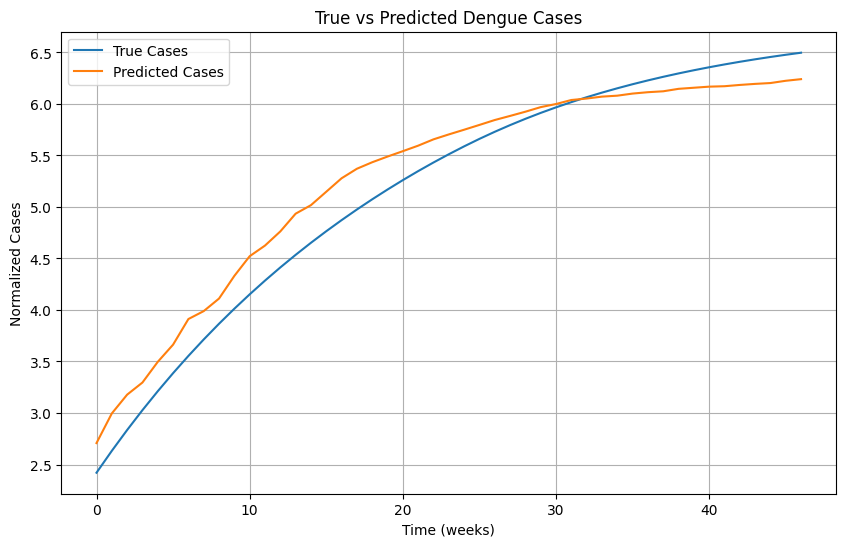

In [10]:
import matplotlib.pyplot as plt

# Plot true vs predicted dengue cases
plt.figure(figsize=(10, 6))
plt.plot(predicted_solution, label='True Cases')
plt.plot(true_solution, label='Predicted Cases')
plt.xlabel('Time (weeks)')
plt.ylabel('Normalized Cases')
plt.title('True vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
criterion = torch.nn.MSELoss()
loss = criterion(predicted_solution, true_solution)
print(f'Mean Squared Error Loss: {loss.item()}')

Mean Squared Error Loss: 0.06549637019634247
